# Загрузка модулей и библиотек

In [1]:
!pip install statsmodels
!pip install scipy
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import welch
#from scipy.signal.windows import hanning
from scipy.signal.windows import blackman

#from pmdarima.arima.utils import ndiffs
import matplotlib.dates as mdates
#from matplotlib.ticker import MaxNLocator, AutoMinorLocator
from matplotlib.dates import HourLocator, MinuteLocator
from matplotlib.ticker import AutoMinorLocator

# Загрузка исходных данных

In [3]:
from google.colab import files
uploaded = files.upload()
uploaded = files.upload()

Saving 14_2024-03-05_2024-09-05.xlsx to 14_2024-03-05_2024-09-05.xlsx


Saving 14_2024-09-05_2025-03-05.xlsx to 14_2024-09-05_2025-03-05.xlsx


In [4]:
# Читаем данные из первого листа файла Excel
df_1 = pd.read_excel('/content/14_2024-03-05_2024-09-05.xlsx', engine='openpyxl')
df_2 = pd.read_excel('/content/14_2024-09-05_2025-03-05.xlsx', engine='openpyxl')

df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 685201 entries, 0 to 685200
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   layer           685201 non-null  int64         
 1   archive_itemid  685201 non-null  int64         
 2   source_time     685201 non-null  datetime64[ns]
 3   value           685201 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 20.9 MB


In [5]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 686976 entries, 0 to 686975
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   layer           686976 non-null  int64         
 1   archive_itemid  686976 non-null  int64         
 2   source_time     686976 non-null  datetime64[ns]
 3   value           686976 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 21.0 MB


In [6]:
# Объединение двух датафреймов
df = pd.concat([df_1, df_2], ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372177 entries, 0 to 1372176
Data columns (total 4 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   layer           1372177 non-null  int64         
 1   archive_itemid  1372177 non-null  int64         
 2   source_time     1372177 non-null  datetime64[ns]
 3   value           1372177 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 41.9 MB


In [7]:
# Читаем данные из первого листа файла Excel
#df = pd.read_excel('/content/14_2024-03-05_2024-09-05.xlsx', engine='openpyxl')

# Проверяем, существует ли колонка source_time
if 'source_time' in df.columns:
    # Преобразовываем source_time в объект datetime
    df['source_time'] = pd.to_datetime(df['source_time'])

    # Разделяем source_time на дату и время
    df['date'] = df['source_time'].dt.date
    df['time'] = df['source_time'].dt.time

    # Преобразуем time, чтобы отбросить секунды
    df['time'] = df['time'].apply(lambda t: t.replace(second=0))

# Показываем первые пять строк для проверки
print(df.head())

   layer  archive_itemid         source_time  value        date      time
0      1              14 2024-03-05 12:04:31    332  2024-03-05  12:04:00
1      1              14 2024-03-05 12:04:59    335  2024-03-05  12:04:00
2      1              14 2024-03-05 12:05:00    334  2024-03-05  12:05:00
3      1              14 2024-03-05 12:05:05    340  2024-03-05  12:05:00
4      1              14 2024-03-05 12:05:59    294  2024-03-05  12:05:00


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372177 entries, 0 to 1372176
Data columns (total 6 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   layer           1372177 non-null  int64         
 1   archive_itemid  1372177 non-null  int64         
 2   source_time     1372177 non-null  datetime64[ns]
 3   value           1372177 non-null  int64         
 4   date            1372177 non-null  object        
 5   time            1372177 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 62.8+ MB


In [9]:
# Группируем данные по дате и времени (минуты), выбираем строку с минимальной секундой
df_grouped = df.sort_values(by=['source_time']) \
               .groupby(['date', 'time'], as_index=False) \
               .first()

# Показываем результат
print(df_grouped.head())
print(len(df_grouped))
df_grouped.info()

         date      time  layer  archive_itemid         source_time  value
0  2024-03-05  12:04:00      1              14 2024-03-05 12:04:31    332
1  2024-03-05  12:05:00      1              14 2024-03-05 12:05:00    334
2  2024-03-05  12:06:00      1              14 2024-03-05 12:06:00    295
3  2024-03-05  12:07:00      1              14 2024-03-05 12:07:00    160
4  2024-03-05  12:08:00      1              14 2024-03-05 12:08:00    167
427440
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427440 entries, 0 to 427439
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            427440 non-null  object        
 1   time            427440 non-null  object        
 2   layer           427440 non-null  int64         
 3   archive_itemid  427440 non-null  int64         
 4   source_time     427440 non-null  datetime64[ns]
 5   value           427440 non-null  int64         
dtypes: datetim

In [10]:
# Определяем минимальную и максимальную даты
min_date = df_grouped['date'].min()
max_date = df_grouped['date'].max()

# Генерируем все возможные даты между min_date и max_date
dates = pd.date_range(min_date, max_date, freq='D')

# Генерируем все возможные минуты в течение дня
minutes = pd.date_range('00:00', '23:59', freq='min').time

# Создаем DataFrame с полными датами и минутами
df_base = pd.DataFrame({
    'date': np.repeat(dates, len(minutes)),
    'time': np.tile(minutes, len(dates))
})

# Преобразуем time в формат HH:MM
df_base['time'] = df_base['time'].astype(str).str.slice(0, 5)

df_base.info()
print(len(df_base))
print(min_date)
print(max_date)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527040 entries, 0 to 527039
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    527040 non-null  datetime64[ns]
 1   time    527040 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 8.0+ MB
527040
2024-03-05
2025-03-05


In [11]:
# Преобразуем столбец 'date' в df_base в формат datetime64[ns]
df_base['date'] = pd.to_datetime(df_base['date'])

# Преобразуем столбец 'date' в df_grouped в формат datetime64[ns]
df_grouped['date'] = pd.to_datetime(df_grouped['date'])

# Приводим столбец 'time' в df_base к формату 'HH:MM'
df_base['time'] = df_base['time'].str.slice(0, 5)

# Приводим столбец 'time' в df_grouped к формату 'HH:MM'
df_grouped['time'] = df_grouped['time'].astype(str).str.slice(0, 5)

# Объединяем df_base с df_grouped по дате и времени
result_df = df_base.merge(df_grouped, how='left', on=['date', 'time'])

# Заполняем пропущенные значения value, перенося последние известные значения вперед
#result_df['value'] = result_df['value'].fillna(method='ffill')

# Линейная интерполяция для заполнения пропущенных значений value
result_df['value'] = result_df['value'].interpolate()

# Показываем результат
print(result_df.head())
result_df.info()
print(len(result_df))

        date   time  layer  archive_itemid source_time  value
0 2024-03-05  00:00    NaN             NaN         NaT    NaN
1 2024-03-05  00:01    NaN             NaN         NaT    NaN
2 2024-03-05  00:02    NaN             NaN         NaT    NaN
3 2024-03-05  00:03    NaN             NaN         NaT    NaN
4 2024-03-05  00:04    NaN             NaN         NaT    NaN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527040 entries, 0 to 527039
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            527040 non-null  datetime64[ns]
 1   time            527040 non-null  object        
 2   layer           427440 non-null  float64       
 3   archive_itemid  427440 non-null  float64       
 4   source_time     427440 non-null  datetime64[ns]
 5   value           526316 non-null  float64       
dtypes: datetime64[ns](2), float64(3), object(1)
memory usage: 24.1+ MB
527040


In [12]:
#  Удаляем NaN
result_df_no_na = result_df.dropna(subset=['value'])
# Показываем результат
print(result_df_no_na.head())
result_df_no_na.info()
print(len(result_df_no_na))

          date   time  layer  archive_itemid         source_time  value
724 2024-03-05  12:04    1.0            14.0 2024-03-05 12:04:31  332.0
725 2024-03-05  12:05    1.0            14.0 2024-03-05 12:05:00  334.0
726 2024-03-05  12:06    1.0            14.0 2024-03-05 12:06:00  295.0
727 2024-03-05  12:07    1.0            14.0 2024-03-05 12:07:00  160.0
728 2024-03-05  12:08    1.0            14.0 2024-03-05 12:08:00  167.0
<class 'pandas.core.frame.DataFrame'>
Index: 526316 entries, 724 to 527039
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            526316 non-null  datetime64[ns]
 1   time            526316 non-null  object        
 2   layer           427440 non-null  float64       
 3   archive_itemid  427440 non-null  float64       
 4   source_time     427440 non-null  datetime64[ns]
 5   value           526316 non-null  float64       
dtypes: datetime64[ns](2), float64(3)

# Аннотирование временного ряда

In [29]:
# В копию df добавляем колонку 'mode' - режим работы

df_mode = result_df_no_na.copy()
df_mode['mode'] = 0

#df_mode.info()
#print(len(df_mode))
print(f"{len(df_mode):,.0f}")

526,316


**Фильтр по заданному дню**

In [30]:
# Фильтруем данные за 2024-06-25
df_one_day = df_mode.loc[df_mode['date'] == '2024-06-25']

# Переиндексация датафрейма
df_one_day_reset = df_one_day.reset_index(drop=True)
# Вывод индекса первого элемента
print(f"Индекс первого элемента: {df_one_day_reset.index[0]}")

# Вывод индекса последнего элемента
print(f"Индекс последнего элемента: {df_one_day_reset.index[-1]}")


print(f"{len(df_one_day):,.0f}")
df_one_day.info()

Индекс первого элемента: 0
Индекс последнего элемента: 1439
1,440
<class 'pandas.core.frame.DataFrame'>
Index: 1440 entries, 161280 to 162719
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            1440 non-null   datetime64[ns]
 1   time            1440 non-null   object        
 2   layer           1018 non-null   float64       
 3   archive_itemid  1018 non-null   float64       
 4   source_time     1018 non-null   datetime64[ns]
 5   value           1440 non-null   float64       
 6   mode            1440 non-null   int64         
dtypes: datetime64[ns](2), float64(3), int64(1), object(1)
memory usage: 90.0+ KB


**Фильтр по заданному интервалу дней**

In [31]:
def filter_dataframe_by_date_range(df, start_day, end_day):
  """
  Фильтрует DataFrame по диапазону дат от start_day до end_day включительно.

  Args:
    df (pd.DataFrame): Исходный DataFrame с колонкой 'date' в формате datetime или строковом формате,
                      приводимом к datetime.
    start_day (str): Начальная дата периода в формате 'YYYY-MM-DD'.
    end_day (str): Конечная дата периода в формате 'YYYY-MM-DD'.

  Returns:
    pd.DataFrame: Отфильтрованный DataFrame, переиндексированный.  Возвращает пустой DataFrame, если исходный DataFrame пуст,
                  если start_day или end_day не в нужном формате, или если start_day > end_day.
  """

  if df.empty:
    return pd.DataFrame()

  try:
    start_date = pd.to_datetime(start_day)
    end_date = pd.to_datetime(end_day)
  except ValueError:
    print("Ошибка: Неправильный формат даты. Используйте формат YYYY-MM-DD.")
    return pd.DataFrame()

  if start_date > end_date:
    print("Ошибка: Начальная дата должна быть раньше или равна конечной дате.")
    return pd.DataFrame()

  # Убеждаемся, что колонка 'date' имеет тип datetime.  Если нет, пытаемся преобразовать.
  if not pd.api.types.is_datetime64_any_dtype(df['date']):
    try:
      df['date'] = pd.to_datetime(df['date'])
    except ValueError:
      print("Ошибка: Колонка 'date' не может быть преобразована в формат datetime.")
      return pd.DataFrame()
    except KeyError:
      print("Ошибка: В DataFrame отсутствует колонка 'date'.")
      return pd.DataFrame()

  # Фильтруем DataFrame по диапазону дат.
  filtered_df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

  # Переиндексируем DataFrame.
  filtered_df_reset = filtered_df.reset_index(drop=True)

  return filtered_df_reset



start_day = '2024-07-01'
end_day = '2024-07-31'

# Важно использовать copy(), чтобы не изменять исходный DataFrame
df_interval = filter_dataframe_by_date_range(df_mode.copy(), start_day, end_day)

if not df_interval.empty:
  print(df_interval)
  print(f"Индекс первого элемента: {df_interval.index[0]}")
else:
  print("DataFrame после фильтрации пуст.")


print(f"Число значений в интервале: {len(df_interval):,.0f}")
df_interval.info()

            date   time  layer  archive_itemid         source_time  \
0     2024-07-01  00:00    NaN             NaN                 NaT   
1     2024-07-01  00:01    NaN             NaN                 NaT   
2     2024-07-01  00:02    NaN             NaN                 NaT   
3     2024-07-01  00:03    NaN             NaN                 NaT   
4     2024-07-01  00:04    NaN             NaN                 NaT   
...          ...    ...    ...             ...                 ...   
44635 2024-07-31  23:55    1.0            14.0 2024-07-31 23:55:00   
44636 2024-07-31  23:56    1.0            14.0 2024-07-31 23:56:00   
44637 2024-07-31  23:57    1.0            14.0 2024-07-31 23:57:00   
44638 2024-07-31  23:58    1.0            14.0 2024-07-31 23:58:00   
44639 2024-07-31  23:59    1.0            14.0 2024-07-31 23:59:00   

            value  mode  
0      187.384615     0  
1      185.769231     0  
2      184.153846     0  
3      182.538462     0  
4      180.923077     0  
...

**Функция задания mode=1**

In [32]:
import pandas as pd

def set_mode(df, level, period_in_minutes):
    """
    Устанавливает значение 'mode' в датафрейме на основе порогового значения 'level' и периода 'period'.

    :param df: Датафрейм
    :param level: Пороговое значение для колонки 'value'
    :param period_in_minutes: Период в минутах для определения диапазона времени
    :return: Датафрейм с установленным значением 'mode'
    """
    # Преобразуем период в объект TimeDelta
    period = pd.Timedelta(minutes=period_in_minutes)

    # Создаем копию датафрейма, чтобы не изменять исходный
    df_copy = df.copy()

    # Переиндексируем датафрейм для обеспечения последовательных индексов
    df_copy = df_copy.reset_index(drop=True)

    condition_met = False  # Флаг для отслеживания выполнения условия
    start_time = None  # Переменная для хранения времени начала аннотирования

    # Проходим по строкам датафрейма
    for i, row in df_copy.iterrows():
        value = row['value']
        source_time = row['source_time']

        if value > level:
            # Определяем начало и конец временного интервала
            start_time = source_time
            end_time = start_time + period

            # Фильтруем строки в пределах временного интервала
            mask = (df_copy['source_time'] >= start_time) & (df_copy['source_time'] <= end_time)
            selected_rows = df_copy[mask]

            # Вычисляем среднее арифметическое значение 'value' в интервале
            mean_value = selected_rows['value'].mean()
            #print(f"Среднее арифметическое значение 'value' в интервале: {mean_value}")

            if mean_value > level:
                # Находим индекс строки, соответствующей start_time
                index_start_time = df_copy.index[df_copy['source_time'] == start_time][0]
                #print('index_start_time:', index_start_time)
                #print('len(df_copy):', len(df_copy))
                for j in range(index_start_time, len(df_copy)):
                    #if df_copy.loc[j, 'value'] != 0:
                    if df_copy.loc[j, 'value'] > 5:
                        df_copy.loc[j, 'mode'] = 1
                    else:
                        break  # Прерываем цикл, если нашли строку с value = 0
                #print(f"mode=1 установлено для строк начиная с {start_time} до первой строки, где value = 0")
                condition_met = True  # Условие выполнено
                #break

    # Если ни одно значение не подходит, возвращаем исходный датафрейм
    if not condition_met:
        print("mode=0 не был изменён, условие mean_value > level не было выполнено.")
    else:
        print(f"Количество строк с mode=0: {(df_copy['mode'] == 0).sum()}")
        print(f"Количество строк с mode=1: {(df_copy['mode'] == 1).sum()}")

    return df_copy

In [33]:
level = 180
period_in_minutes = 10

# Устанавливаем mode для датасета "df_one_day"
annotated_df = set_mode(df_one_day, level, period_in_minutes)


# Устанавливаем mode для датасета "df_interval"
#annotated_df = set_mode(df_interval, level, period_in_minutes)

#annotated_df = set_mode(df_mode, level, period_in_minutes)

Количество строк с mode=0: 197
Количество строк с mode=1: 1243


**График временного ряда за весь период**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_value_by_source_time(df):
    """
    Рисует график значений 'value' по времени 'source_time' с использованием цветов для обозначения 'mode'.

    :param df: Датафрейм с данными
    """
    # Создаем фигуру и оси для графика
    fig, ax = plt.subplots(figsize=(12, 6))

    # Удаляем строки с NaT значениями в source_time
    df = df.dropna(subset=['source_time'])

    # Формируем маски для разделения данных по значению 'mode'
    mask_mode_0 = df['mode'] == 0
    mask_mode_1 = df['mode'] == 1

    # Рисуем точки для mode=0 красным цветом
    ax.scatter(
        x=df.loc[mask_mode_0, 'source_time'],
        y=df.loc[mask_mode_0, 'value'],
        marker='.',  # Вид маркеров (точек)
        s=2,  # Размер точек
        #color='red',  # Цвет точек
        color='lightcoral',  # Светло-красный цвет точек
        label='Mode = 0'  # Легенда
    )

    # Рисуем точки для mode=1 зеленым цветом
    ax.scatter(
        x=df.loc[mask_mode_1, 'source_time'],
        y=df.loc[mask_mode_1, 'value'],
        marker='.',  # Вид маркеров (точек)
        s=2,  # Размер точек
        #color='green',  # Цвет точек
        color='lightgreen',
        label='Mode = 1'  # Легенда
    )

    # Рисуем линии между точками
    #colors = {'0': 'red', '1': 'green'}  # Соответствие между mode и цветом линии
    #transition_color = 'yellow'  # Цвет для линий переходов

    colors = {'0': 'lightcoral', '1': 'lightgreen'}  # Соответствие между mode и цветом линии
    transition_color = 'orange'  # Оранжевый цвет для линий переходов


    # Цикл для рисования линий
    for i in range(1, len(df)):
        prev_mode = str(df.iloc[i-1]['mode'])
        curr_mode = str(df.iloc[i]['mode'])

        # Определяем цвет линии
        if prev_mode == curr_mode:
            line_color = colors[prev_mode]
        else:
            line_color = transition_color

        # Рисуем линию между точками
        ax.plot(
            [df.iloc[i-1]['source_time'], df.iloc[i]['source_time']],
            [df.iloc[i-1]['value'], df.iloc[i]['value']],
            marker='',  # Без маркеров
            linestyle='-',  # Линия между точками
            linewidth=1,  # Толщина линии
            color=line_color,  # Цвет линии
            label=f'Mode Transition ({prev_mode} -> {curr_mode})' if prev_mode != curr_mode else ''
        )

    # Настройки графика
    ax.set_xlabel('Время (source_time)')
    ax.set_ylabel('Значение (value)')
    #ax.legend()
    ax.grid(True)

    # Показ графика
    plt.show()




# Пример использования функции
#plot_value_by_source_time(annotated_df)

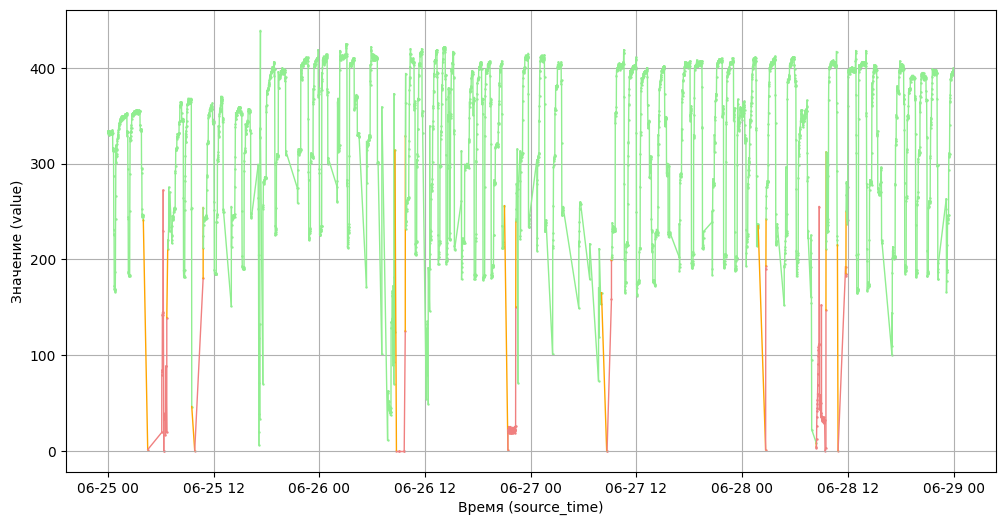

In [ ]:
# Пример использования функции
plot_value_by_source_time(annotated_df)

**График временного ряда с заданием диапазона даты и времени**

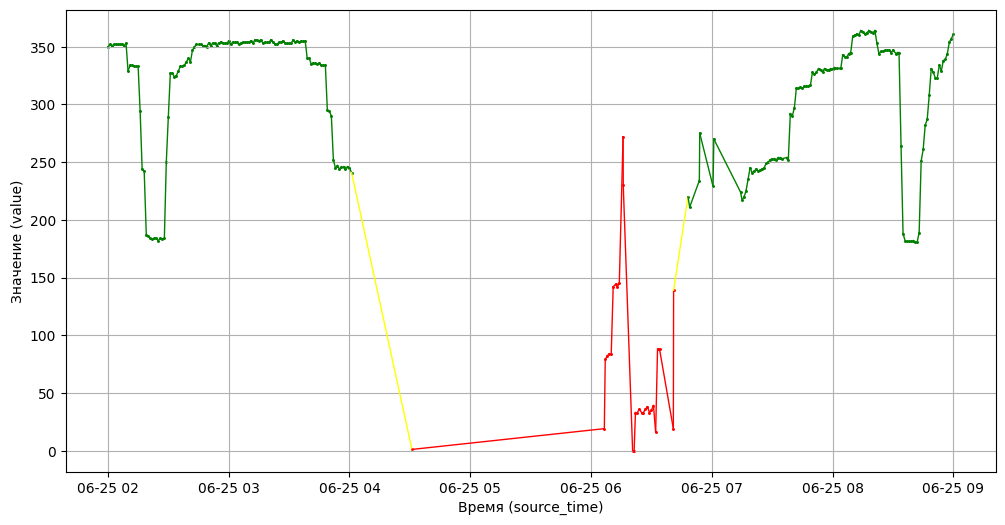

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_value_by_source_time(df, start_time_range=None, end_time_range=None):
    """
    Рисует график значений 'value' по времени 'source_time' с использованием цветов для обозначения 'mode'.

    :param df: Датафрейм с данными
    :param start_time_range: Начальное время для ограничения диапазона (optional)
    :param end_time_range: Конечное время для ограничения диапазона (optional)
    """
    # Создаем фигуру и оси для графика
    fig, ax = plt.subplots(figsize=(12, 6))

    # Преобразуем столбец 'source_time' в формат datetime
    df['source_time'] = pd.to_datetime(df['source_time'])

    # Применяем фильтры по времени, если указаны
    if start_time_range is not None:
        df = df[df['source_time'] >= start_time_range]
    if end_time_range is not None:
        df = df[df['source_time'] <= end_time_range]

    # Удаляем строки с NaT значениями в source_time
    df = df.dropna(subset=['source_time'])

    # Формируем маски для разделения данных по значению 'mode'
    mask_mode_0 = df['mode'] == 0
    mask_mode_1 = df['mode'] == 1

    # Рисуем точки для mode=0 красным цветом
    ax.scatter(
        x=df.loc[mask_mode_0, 'source_time'],
        y=df.loc[mask_mode_0, 'value'],
        marker='.',  # Вид маркеров (точек)
        s=5,  # Размер точек
        color='red',  # Цвет точек
        label='Mode = 0'  # Легенда
    )

    # Рисуем точки для mode=1 зеленым цветом
    ax.scatter(
        x=df.loc[mask_mode_1, 'source_time'],
        y=df.loc[mask_mode_1, 'value'],
        marker='.',  # Вид маркеров (точек)
        s=5,  # Размер точек
        color='green',  # Цвет точек
        label='Mode = 1'  # Легенда
    )

    # Рисуем линии между точками
    colors = {'0': 'red', '1': 'green'}  # Соответствие между mode и цветом линии
    transition_color = 'yellow'  # Цвет для линий переходов

    # Цикл для рисования линий
    for i in range(1, len(df)):
        prev_mode = str(df.iloc[i-1]['mode'])
        curr_mode = str(df.iloc[i]['mode'])

        # Определяем цвет линии
        if prev_mode == curr_mode:
            line_color = colors[prev_mode]
        else:
            line_color = transition_color

        # Рисуем линию между точками
        ax.plot(
            [df.iloc[i-1]['source_time'], df.iloc[i]['source_time']],
            [df.iloc[i-1]['value'], df.iloc[i]['value']],
            marker='',  # Без маркеров
            linestyle='-',  # Линия между точками
            linewidth=1,  # Толщина линии
            color=line_color,  # Цвет линии
            label=f'Mode Transition ({prev_mode} -> {curr_mode})' if prev_mode != curr_mode else ''
        )

    # Настройки графика
    ax.set_xlabel('Время (source_time)')
    ax.set_ylabel('Значение (value)')
    #ax.legend()
    ax.grid(True)

    # Показ графика
    plt.show()

# Пример использования функции
plot_value_by_source_time(annotated_df, start_time_range='2024-06-25 02:00', end_time_range='2024-06-25 09:00')

# Сохранение данных

**Сохранение датафрейма**

In [ ]:
import os
import pandas as pd

def save_dataframe_to_file(df, file_path, file_name):
    """ Сохраняет датафрейм в файл CSV с заданным путем и названием. :param df: Датафрейм для сохранения :param file_path: Путь к директории для сохранения файла :param file_name: Имя файла для сохранения """
    # Создаём каталог, если он не существует
    os.makedirs(file_path, exist_ok=True)

    full_path = f"{file_path}/{file_name}.csv"
    df.to_csv(full_path, index=False)
    print(f"Датафрейм сохранен в файл: {full_path}")


def load_and_merge_dataframes(file_path, file_names):
    """ Загружает и объединяет несколько датафреймов из файлов CSV. :param file_path: Путь к директории, где хранятся файлы :param file_names: Список имен файлов для загрузки :return: Объединенный датафрейм """
    dfs = []  # Список для хранения загруженных датафреймов
    for file_name in file_names:
        full_path = f"{file_path}/{file_name}.csv"
        df = pd.read_csv(full_path)
        dfs.append(df)

    # Объединение датафреймов по вертикали (stacking)
    merged_df = pd.concat(dfs, ignore_index=True)

    return merged_df

In [ ]:
# Пример сохранения датафрейма
file_path = r"C:\Users\Андрей\Documents\Курсы\AI_ML_разработчик\Стажировка_1\Задача_1\Данные от заказчика\рабочий каталог"
save_dataframe_to_file(annotated_df, file_path, "annotated_df_07_2024")


Датафрейм сохранен в файл: C:\Users\Андрей\Documents\Курсы\AI_ML_разработчик\Стажировка_1\Задача_1\Данные от заказчика\рабочий каталог/annotated_df_07_2024.csv


In [14]:
from google.colab import files
uploaded = files.upload()


Saving annotated_df_06_2024.csv to annotated_df_06_2024.csv


In [18]:
if uploaded:  # Проверяем, что хотя бы один файл был загружен
  filename = next(iter(uploaded)) # Получаем имя первого загруженного файла

  try:
    df_06_2024 = pd.read_csv(filename)
    print(df_06_2024.head())
  except FileNotFoundError:
    print(f"Ошибка: Файл '{filename}' не найден.")
  except Exception as e:
    print(f"Произошла ошибка: {e}")
else:
  print("Файл не был загружен.")

         date   time  layer  archive_itemid source_time       value  mode
0  2024-06-01  00:00    NaN             NaN         NaN  120.000000     0
1  2024-06-01  00:01    NaN             NaN         NaN  111.571429     0
2  2024-06-01  00:02    NaN             NaN         NaN  103.142857     0
3  2024-06-01  00:03    NaN             NaN         NaN   94.714286     0
4  2024-06-01  00:04    NaN             NaN         NaN   86.285714     0


**Формирование и сохранение сводного датафрейма**

In [4]:
from google.colab import files
import io

# Создаем пустой список для хранения датафреймов из каждого файла
dfs = []

# Загружаем файлы в цикле
for i in range(1, 14):  # Исправлено: цикл до 14, чтобы прочитать 13 файлов (1-13)
    print(f"Загрузите файл {i} из 13...") # Подсказка пользователю, какой файл нужно загрузить

    uploaded = files.upload()

    # Проверяем, что файл был загружен
    if len(uploaded) > 0:
        # Получаем имя файла (ключ в словаре uploaded)
        filename = list(uploaded.keys())[0]

        # Читаем CSV файл в DataFrame
        try:
            df = pd.read_csv(io.BytesIO(uploaded[filename])) # Используем io.BytesIO для чтения из памяти
            dfs.append(df) # Добавляем DataFrame в список
            print(f"Файл {filename} успешно загружен и обработан.")
        except Exception as e:
            print(f"Ошибка при чтении файла {filename}: {e}")
    else:
        print("Файл не был загружен. Проверьте загрузку.")

# Объединяем все DataFrame в один
if dfs: # Проверяем, что список dfs не пустой
    df_consolidated = pd.concat(dfs, ignore_index=True) # Объединяем DataFrame
    print("Все файлы успешно объединены в df_consolidated.")
else:
    print("Не было загружено ни одного файла. df_consolidated не создан.")

# Теперь df_consolidated содержит все данные из всех CSV файлов

# (Опционально) Вывод первых нескольких строк объединенного DataFrame
if 'df_consolidated' in locals(): # Проверяем, что переменная существует
    print(df_consolidated.head())

Загрузите файл 1 из 13...


Saving annotated_df_01_2025.csv to annotated_df_01_2025 (1).csv
Файл annotated_df_01_2025 (1).csv успешно загружен и обработан.
Загрузите файл 2 из 13...


Saving annotated_df_02_2025.csv to annotated_df_02_2025 (1).csv
Файл annotated_df_02_2025 (1).csv успешно загружен и обработан.
Загрузите файл 3 из 13...


Saving annotated_df_03_2024.csv to annotated_df_03_2024 (1).csv
Файл annotated_df_03_2024 (1).csv успешно загружен и обработан.
Загрузите файл 4 из 13...


Saving annotated_df_03_2025.csv to annotated_df_03_2025 (1).csv
Файл annotated_df_03_2025 (1).csv успешно загружен и обработан.
Загрузите файл 5 из 13...


Saving annotated_df_04_2024.csv to annotated_df_04_2024 (1).csv
Файл annotated_df_04_2024 (1).csv успешно загружен и обработан.
Загрузите файл 6 из 13...


Saving annotated_df_05_2024.csv to annotated_df_05_2024 (1).csv
Файл annotated_df_05_2024 (1).csv успешно загружен и обработан.
Загрузите файл 7 из 13...


Saving annotated_df_06_2024.csv to annotated_df_06_2024 (1).csv
Файл annotated_df_06_2024 (1).csv успешно загружен и обработан.
Загрузите файл 8 из 13...


Saving annotated_df_07_2024.csv to annotated_df_07_2024 (1).csv
Файл annotated_df_07_2024 (1).csv успешно загружен и обработан.
Загрузите файл 9 из 13...


Saving annotated_df_08_2024.csv to annotated_df_08_2024 (1).csv
Файл annotated_df_08_2024 (1).csv успешно загружен и обработан.
Загрузите файл 10 из 13...


Saving annotated_df_09_2024.csv to annotated_df_09_2024 (1).csv
Файл annotated_df_09_2024 (1).csv успешно загружен и обработан.
Загрузите файл 11 из 13...


Saving annotated_df_10_2024.csv to annotated_df_10_2024 (1).csv
Файл annotated_df_10_2024 (1).csv успешно загружен и обработан.
Загрузите файл 12 из 13...


Saving annotated_df_11_2024.csv to annotated_df_11_2024 (1).csv
Файл annotated_df_11_2024 (1).csv успешно загружен и обработан.
Загрузите файл 13 из 13...


Saving annotated_df_12_2024.csv to annotated_df_12_2024.csv
Файл annotated_df_12_2024.csv успешно загружен и обработан.
Все файлы успешно объединены в df_consolidated.
         date   time  layer  archive_itemid source_time  value  mode
0  2025-01-01  00:00    NaN             NaN         NaN    0.0     0
1  2025-01-01  00:01    NaN             NaN         NaN    0.0     0
2  2025-01-01  00:02    NaN             NaN         NaN    0.0     0
3  2025-01-01  00:03    NaN             NaN         NaN    0.0     0
4  2025-01-01  00:04    NaN             NaN         NaN    0.0     0


In [46]:
from google.colab import files
import io

# Создаем пустой список для хранения датафреймов из каждого файла
dfs = []

# Загружаем файлы в цикле
for i in range(1, 14):  # Исправлено: цикл до 14, чтобы прочитать 13 файлов (1-13)
    print(f"Загрузите файл {i} из 13...") # Подсказка пользователю, какой файл нужно загрузить

    uploaded = files.upload()

    # Проверяем, что файл был загружен
    if len(uploaded) > 0:
        # Получаем имя файла (ключ в словаре uploaded)
        filename = list(uploaded.keys())[0]

        # Читаем CSV файл в DataFrame
        try:
            df = pd.read_csv(io.BytesIO(uploaded[filename])) # Используем io.BytesIO для чтения из памяти

            # Преобразуем 'source_time' в datetime, если он еще не в этом формате
            df['source_time'] = pd.to_datetime(df['source_time'])

            # Обрезаем время до минут (формат: 'YYYY-MM-DD HH:MM')
            df['source_time'] = df['source_time'].dt.strftime('%Y-%m-%d %H:%M')

            # Удаляем дубликаты по столбцу 'source_time', оставляя первое вхождение
            df = df.drop_duplicates(subset=['source_time'], keep='first')


            dfs.append(df) # Добавляем DataFrame в список
            print(f"Файл {filename} успешно загружен и обработан.")
        except Exception as e:
            print(f"Ошибка при чтении файла {filename}: {e}")
    else:
        print("Файл не был загружен. Проверьте загрузку.")

# Объединяем все DataFrame в один
if dfs: # Проверяем, что список dfs не пустой
    df_consolidated = pd.concat(dfs, ignore_index=True) # Объединяем DataFrame
    print("Все файлы успешно объединены в df_consolidated.")
else:
    print("Не было загружено ни одного файла. df_consolidated не создан.")

# Теперь df_consolidated содержит все данные из всех CSV файлов

# (Опционально) Вывод первых нескольких строк объединенного DataFrame
if 'df_consolidated' in locals(): # Проверяем, что переменная существует
    print(df_consolidated.head())

Загрузите файл 1 из 13...


Saving annotated_df_01_2025.csv to annotated_df_01_2025.csv
Файл annotated_df_01_2025.csv успешно загружен и обработан.
Загрузите файл 2 из 13...


Saving annotated_df_02_2025.csv to annotated_df_02_2025.csv
Файл annotated_df_02_2025.csv успешно загружен и обработан.
Загрузите файл 3 из 13...


Saving annotated_df_03_2024.csv to annotated_df_03_2024.csv
Файл annotated_df_03_2024.csv успешно загружен и обработан.
Загрузите файл 4 из 13...


Saving annotated_df_03_2025.csv to annotated_df_03_2025.csv
Файл annotated_df_03_2025.csv успешно загружен и обработан.
Загрузите файл 5 из 13...


Saving annotated_df_04_2024.csv to annotated_df_04_2024.csv
Файл annotated_df_04_2024.csv успешно загружен и обработан.
Загрузите файл 6 из 13...


Saving annotated_df_05_2024.csv to annotated_df_05_2024.csv
Файл annotated_df_05_2024.csv успешно загружен и обработан.
Загрузите файл 7 из 13...


Saving annotated_df_06_2024.csv to annotated_df_06_2024.csv
Файл annotated_df_06_2024.csv успешно загружен и обработан.
Загрузите файл 8 из 13...


Saving annotated_df_07_2024.csv to annotated_df_07_2024.csv
Файл annotated_df_07_2024.csv успешно загружен и обработан.
Загрузите файл 9 из 13...


Saving annotated_df_08_2024.csv to annotated_df_08_2024.csv
Файл annotated_df_08_2024.csv успешно загружен и обработан.
Загрузите файл 10 из 13...


Saving annotated_df_09_2024.csv to annotated_df_09_2024.csv
Файл annotated_df_09_2024.csv успешно загружен и обработан.
Загрузите файл 11 из 13...


Saving annotated_df_10_2024.csv to annotated_df_10_2024.csv
Файл annotated_df_10_2024.csv успешно загружен и обработан.
Загрузите файл 12 из 13...


Saving annotated_df_11_2024.csv to annotated_df_11_2024.csv
Файл annotated_df_11_2024.csv успешно загружен и обработан.
Загрузите файл 13 из 13...


Saving annotated_df_12_2024.csv to annotated_df_12_2024.csv
Файл annotated_df_12_2024.csv успешно загружен и обработан.
Все файлы успешно объединены в df_consolidated.
         date   time  layer  archive_itemid       source_time  value  mode
0  2025-01-01  00:00    NaN             NaN               NaN    0.0     0
1  2025-01-04  05:12    1.0            14.0  2025-01-04 05:12    0.0     0
2  2025-01-04  05:14    1.0            14.0  2025-01-04 05:14    0.0     0
3  2025-01-04  05:15    1.0            14.0  2025-01-04 05:15    0.0     0
4  2025-01-04  05:17    1.0            14.0  2025-01-04 05:17    0.0     0


In [48]:
# Сохраняем сводный датафрейм в файле df_consolidated.csv
index = False
df_consolidated.to_csv('df_consolidated.csv', encoding='utf-8', index=index)  # Используем определенную переменную

print("DataFrame успешно сохранен в файл: df_consolidated.csv")

DataFrame успешно сохранен в файл: df_consolidated.csv


**Преобразуем сводный датафрейм**

In [49]:
from google.colab import files
import io

uploaded = files.upload()

# Проверяем, что файл был загружен
if len(uploaded) > 0:
    # Получаем имя файла (ключ в словаре uploaded)
    filename = list(uploaded.keys())[0]

    # Читаем CSV файл в DataFrame
    try:
        df = pd.read_csv(io.BytesIO(uploaded[filename]))
    except Exception as e:
        print(f"Ошибка при чтении файла {filename}: {e}")
else:
    print("Файл не был загружен. Проверьте загрузку.")

print(df.head())

Saving df_consolidated.csv to df_consolidated.csv
         date   time  layer  archive_itemid       source_time  value  mode
0  2025-01-01  00:00    NaN             NaN               NaN    0.0     0
1  2025-01-04  05:12    1.0            14.0  2025-01-04 05:12    0.0     0
2  2025-01-04  05:14    1.0            14.0  2025-01-04 05:14    0.0     0
3  2025-01-04  05:15    1.0            14.0  2025-01-04 05:15    0.0     0
4  2025-01-04  05:17    1.0            14.0  2025-01-04 05:17    0.0     0


In [50]:
# Проводим обработку данных в датафрейме
def process_dataframe(df):


    # 1. Переименование колонки 'value' в 'value_14'
    df = df.rename(columns={'value': 'value_14'})

    # 2. Заполнение пропусков в 'source_time' данными из 'date' и 'time'
    #  Преобразуем дату и время с учетом минут.

    if 'date' in df.columns and 'time' in df.columns:
        # Объединяем 'date' и 'time' в колонку 'datetime_str'
        df['datetime_str'] = df['date'] + ' ' + df['time']

        # Преобразуем 'datetime_str' в datetime объекты
        try:
            df['datetime'] = pd.to_datetime(df['datetime_str'], format='%Y-%m-%d %H:%M')  # Предполагаем формат YYYY-MM-DD HH:MM:SS
            #Если формат другой, нужно заменить
        except ValueError:
            print("Ошибка: Неверный формат даты и времени в колонках 'date' и 'time'.  Пожалуйста, укажите правильный формат.")
            return df # Возвращаем DataFrame без изменений

        # Обрезаем секунды, оставляем только минуты
        df['datetime'] = df['datetime'].dt.strftime('%Y-%m-%d %H:%M') # format = '%Y-%m-%d %H:%M'

        # Заполняем пропуски в 'source_time' полученными значениями
        df['source_time'] = df['source_time'].fillna(df['datetime'])

        # Удаляем временные колонки
        df = df.drop(columns=['datetime_str', 'datetime'], errors='ignore')

    else:
        print("Предупреждение: Колонки 'date' и/или 'time' отсутствуют в DataFrame.")

    # 3. Удаление колонок 'layer' и 'archive_itemid'
    columns_to_drop = ['layer', 'archive_itemid']
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')  #errors='ignore' чтобы не было ошибки, если колонки нет

    # 4. Сортировка колонки по возрастанию значений 'source_time'
    df = df.sort_values(by='source_time', ascending=True)

    return df

df = process_dataframe(df)

df.head()

,date,time,source_time,value_14,mode
77285,2024-03-05,12:04,2024-03-05 12:04,332.0,1
77286,2024-03-05,12:05,2024-03-05 12:05,334.0,1
77287,2024-03-05,12:06,2024-03-05 12:06,295.0,1
77288,2024-03-05,12:07,2024-03-05 12:07,160.0,1
77289,2024-03-05,12:08,2024-03-05 12:08,167.0,1


In [51]:
# Сохраняем сводный датафрейм в файле df_consolidated.csv

index = False
df.to_csv('df_consolidated_1.csv', encoding='utf-8', index=index)  # Используем определенную переменную

print("DataFrame успешно сохранен в файл: df_consolidated_1.csv")

DataFrame успешно сохранен в файл: df_consolidated_1.csv


# Статистический анализ на рабочем режиме

In [52]:
from google.colab import files
import io

uploaded = files.upload()

# Проверяем, что файл был загружен
if len(uploaded) > 0:
    # Получаем имя файла (ключ в словаре uploaded)
    filename = list(uploaded.keys())[0]

    # Читаем CSV файл в DataFrame
    try:
        df = pd.read_csv(io.BytesIO(uploaded[filename]))
    except Exception as e:
        print(f"Ошибка при чтении файла {filename}: {e}")
else:
    print("Файл не был загружен. Проверьте загрузку.")

print(df.head())

Saving df_consolidated.csv to df_consolidated.csv
         date   time       source_time  value_14  mode
0  2024-03-05  12:04  2024-03-05 12:04     332.0     1
1  2024-03-05  12:05  2024-03-05 12:05     334.0     1
2  2024-03-05  12:06  2024-03-05 12:06     295.0     1
3  2024-03-05  12:07  2024-03-05 12:07     160.0     1
4  2024-03-05  12:08  2024-03-05 12:08     167.0     1


# Функции стат. анализа

In [53]:
import pandas as pd
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
from scipy.stats import skew, kurtosis
from tabulate import tabulate

import matplotlib.pyplot as plt
from scipy.signal import coherence
from scipy.signal import welch
from statsmodels.graphics.tsaplots import plot_acf

In [64]:
def calculate_hurst_exponent(time_series, max_lag=50):
    """ Рассчитывает показатель Херста с использованием R/S-анализа. :param time_series: Временной ряд :param max_lag: Максимальное значение лага для анализа :return: Показатель Херста """
    lags = range(2, max_lag)
    rs_analysis = []

    for lag in lags:
        # Создание подпоследовательности длиной lag
        subsequence = np.array([time_series[i:i+lag] for i in range(len(time_series)-lag)])

        # Расчёт средних значений для каждой подпоследовательности
        means = np.mean(subsequence, axis=1)

        # Расчёт накопленной суммы отклонений
        cumulative_deviations = np.cumsum(subsequence - means[:, np.newaxis], axis=1)

        # Расчёт диапазонов R
        ranges = np.ptp(cumulative_deviations, axis=1)

        # Расчёт стандартных отклонений S
        standard_deviations = np.std(subsequence, axis=1)

        # Игнорируем случаи, когда стандартное отклонение равно нулю
        valid_indices = standard_deviations != 0
        ranges = ranges[valid_indices]
        standard_deviations = standard_deviations[valid_indices]

        # Расчёт отношения R/S
        if len(standard_deviations) > 0:
            rs_ratio = np.mean(ranges / standard_deviations)
            rs_analysis.append((lag, rs_ratio))
        else:
            rs_analysis.append((lag, np.nan))

    # Регрессия логарифмов лагов и отношений R/S
    log_lags = np.log10([lag for lag, _ in rs_analysis])
    log_rs_ratios = np.log10([rs_ratio for _, rs_ratio in rs_analysis if not np.isnan(rs_ratio)])

    if len(log_rs_ratios) > 0:
        slope, intercept = np.polyfit(log_lags, log_rs_ratios, deg=1)
        hurst_exponent = slope * 0.5
    else:
        hurst_exponent = np.nan

    return hurst_exponent





def calculate_period_statistics(df, start_datetime, end_datetime, value_col='value'):
    """ Рассчитывает статистику для указанного периода в датафрейме. :param annotated_df: Датафрейм с колонками 'source_time', 'value' и 'mode' :param start_datetime: Начальная дата и время периода (включительно) :param end_datetime: Конечная дата и время периода (включительно) :param value_col: Название колонки с данными, для которых считается статистика :return: Красивый вывод статистики с использованием tabulate """
    # Приводим даты к нужному формату datetime
    try:
        start_datetime = pd.to_datetime(start_datetime)
        end_datetime = pd.to_datetime(end_datetime)
    except ValueError:
        raise ValueError("Неверный формат даты или времени!")

    # Фильтруем строки, где mode=1 и source_time находится в указанном диапазоне
    filtered_df = df[
        (df['source_time'] >= start_datetime) &
        (df['source_time'] <= end_datetime) &
        (df['mode'] == 1)
    ][value_col]

    # Количество точек
    count = len(filtered_df)

    # Проверка на достаточное количество данных для статистики
    if count < 2:
        print(f"ПРЕДУПРЕЖДЕНИЕ: Недостаточно данных ({count}) для расчета некоторых статистических показателей.")

    # Среднее значение
    mean = filtered_df.mean() if count > 0 else float('nan')

    # Максимальное значение
    max_value = filtered_df.max() if count > 0 else float('nan')

    # Минимальное значение
    min_value = filtered_df.min() if count > 0 else float('nan')

    # Медиана
    median = filtered_df.median() if count > 0 else float('nan')

    # Дисперсия
    variance = filtered_df.var() if count > 1 else float('nan')

    # Стандартное отклонение (СКО)
    std_dev = filtered_df.std() if count > 1 else float('nan')

    # Асимметрия
    skewness = skew(filtered_df) if count > 2 else float('nan')

    # Эксцесс
    kurt = kurtosis(filtered_df) if count > 2 else float('nan')

    # Квантили (25%, 50%, 75%)
    quantiles = filtered_df.quantile([0.25, 0.5, 0.75]) if count > 0 else {}

    # Коэффициент автокорреляции
    autocorrelation = acf(filtered_df, nlags=1)[1] if count > 1 else float('nan')

    # Проверка на стационарность (ADF-тест)
    try:
        adf_result = adfuller(filtered_df)
        stationary_p_value = adf_result[1]
    except ValueError as e:
        # Обрабатываем ситуацию, когда данные константны
        if str(e) == "Invalid input, x is constant":
            stationary_p_value = float('nan')
        else:
            stationary_p_value = float('nan')

    # Показатель Херста
    hurst_exponent = calculate_hurst_exponent(filtered_df) if count > 2 else float('nan')

    # Форматируем данные для вывода с помощью tabulate
    headers = ['Показатель', 'Значение']
    data = [
        ('Количество точек', str(count)),
        ('Среднее значение', f"{mean:.6f}"),
        ('Максимальное значение', f"{max_value:.6f}"),  # Интегрируем как float
        ('Минимальное значение', f"{min_value:.6f}"),
        ('Медиана', f"{median:.6f}"),
        ('Дисперсия', f"{variance:.6f}"),
        ('Стандартное отклонение (СКО)', f"{std_dev:.6f}"),
        ('Асимметрия', f"{skewness:.6f}"),
        ('Эксцесс', f"{kurt:.6f}"),
        ('Квантиль 25%', f"{quantiles.get(0.25, float('nan')):.6f}"),
        ('Квантиль 50% (медиана)', f"{quantiles.get(0.5, float('nan')):.6f}"),
        ('Квантиль 75%', f"{quantiles.get(0.75, float('nan')):.6f}"),
        ('Автокорреляция', f"{autocorrelation:.6f}"),
        ('p-значение ADF-теста', f"{stationary_p_value:.6f}"),
        ('Показатель Херста', f"{hurst_exponent:.6f}")
    ]

    # Добавляем строку с указанием периода в выводе
    print(f"Статистика показателя '{value_col}' \nс {start_datetime} по {end_datetime}:")
    print()

    # Используем tabulate для красивого вывода
    print(tabulate(data, headers, tablefmt="github"))
    print()

    # Возвращаем также сам DataFrame для дальнейшей работы
    statistics = pd.DataFrame({
        'Показатели': [
            'Количество точек',
            'Среднее значение',
            'Максимальное значение',
            'Минимальное значение',
            'Медиана',
            'Дисперсия',
            'Стандартное отклонение (СКО)',
            'Асимметрия',
            'Эксцесс',
            'Квантиль 25%',
            'Квантиль 50% (медиана)',
            'Квантиль 75%',
            'Автокорреляция',
            'p-значение ADF-теста',
            'Показатель Херста'
        ],
        'Значения': [
            count,
            mean,
            max_value,
            min_value,
            median,
            variance,
            std_dev,
            skewness,
            kurt,
            quantiles.get(0.25, float('nan')),
            quantiles.get(0.5, float('nan')),
            quantiles.get(0.75, float('nan')),
            autocorrelation,
            stationary_p_value,
            hurst_exponent
        ]
    })

    return statistics

In [79]:
def plot_histogram(filtered_df, value_col='value'):
    """
    Строит гистограмму распределения для выбранной переменной.

    :param filtered_df: Подмножество датафрейма с интересующими данными
    :param value_col: Название колонки с данными, для которых строится гистограмма
    """
    plt.figure(figsize=(10, 5))  # Размер графика
    plt.hist(filtered_df[value_col], bins=100, alpha=0.7)  # Построение гистограммы
    plt.title(f"Гистограмма распределения показателя '{value_col}'")  # Заголовок графика
    plt.xlabel(value_col)  # Метка оси X
    plt.ylabel("Частота")  # Метка оси Y
    plt.grid(True)  # Сетка для удобства чтения
    plt.show()  # Отображение графика


def plot_power_spectral_density(filtered_df, value_col='value'):
    """ Строит график спектральной плотности мощности для выбранной переменной. :param filtered_df: Подмножество датафрейма с интересующими данными :param value_col: Название колонки с данными, для которых строится спектр """
    plt.figure(figsize=(10, 5))  # Размер графика
    f, Pxx_den = welch(filtered_df[value_col], fs=1.0, window='hann', nperseg=256, scaling='density')  # Построение PSD
    plt.semilogy(f, Pxx_den)  # Логарифмический масштаб по оси Y для лучшего отображения
    plt.title(f"Спектральная плотность мощности показателя '{value_col}'")  # Заголовок графика
    plt.xlabel("Частота")  # Метка оси X
    plt.ylabel("Спектральная плотность")  # Метка оси Y
    plt.grid(True)  # Сетка для удобства чтения
    plt.show()  # Отображение графика


# Функция для построения графиков ACF и PACF
def plot_acf_pacf(filtered_df):
    n = len(filtered_df[value])
    max_lags = int(np.sqrt(n))  # Подбор количества лагов согласно правилу Бартлетта

    print(f"Максимальный лаг: {max_lags}")

    plt.figure(figsize=(10, 6))
    plot_acf(filtered_df[value], lags=max_lags, title='Автокорреляционная функция (АКФ)', zero=False)
    plt.show()

    plt.figure(figsize=(10, 6))
    plot_pacf(filtered_df[value], lags=max_lags, title='Частная корреляционная функция (ЧКФ)', zero=False)
    plt.show()

In [82]:
# Функция для построения графика спектральной плотности
def plot_spectral_density(result_df, value):

    # Выбор временного ряда для анализа
    values = result_df[value].values

    # Параметры для оценки спектральной плотности
    fs = 1  # Частота дискретизации (здесь 1, так как это временной ряд)
    nperseg = len(values) // 2  # Размер сегмента (зависит от длины ряда)
    window = blackman(nperseg)  # Применение оконной функции Blackman

    # Оцениваем спектральную плотность мощности с помощью метода Welch
    frequencies, psd = welch(values, fs=fs, nperseg=nperseg, window=window)

    # Построение графика спектральной плотности
    plt.figure(figsize=(10, 6))
    plt.semilogy(frequencies, psd, color='b')  # Логарифмическая шкала для оси Y
    plt.xlim(0, frequencies.max())  # Ограничиваем ось X
    plt.title(f'График сперктральной плотности')
    plt.xlabel('Частота [Гц]')
    plt.ylabel('Спектор мощности')
    plt.grid(True)
    plt.autoscale(enable=True, axis='both', tight=None)  # Автоматическое масштабирование осей
    plt.show()

In [101]:
def stat_consolidated(df, value, start_datetime, end_datetime):


  # Преобразуем столбец source_time в формат datetime с указанием формата
  df['source_time'] = pd.to_datetime(df['source_time'], format="%Y-%m-%d %H:%M")

  # Преобразуем входные параметры start_datetime и end_datetime в формат datetime
  start_datetime = pd.to_datetime(start_datetime, format="%Y-%m-%d %H:%M")
  end_datetime = pd.to_datetime(end_datetime, format="%Y-%m-%d %H:%M")


  # Расчёт статистики
  calculate_period_statistics(df, start_datetime, end_datetime, value)

  # Фильтрация данных для графиков
  filtered_df = df[(df['source_time'] >= start_datetime) & (df['source_time'] <= end_datetime) & (df['mode'] == 1)]

  # Построение гистограммы
  plot_histogram(filtered_df, value)

  # Посстроение графика спектральной плотности
  plot_power_spectral_density(filtered_df, value)
  plot_spectral_density(filtered_df, value)


  # Фильтруем числовые данные
  filtered_values = filtered_df[value]


  # Строим графики ACF и PACF
  plot_acf_pacf(filtered_df)

In [58]:
def fill_source_time(df):
  """
  Заполняет пустые значения в колонке 'source_time' DataFrame `df` значениями,
  сформированными из колонок 'date' и 'time'.

  Args:
    df (pd.DataFrame): DataFrame с колонками 'source_time', 'date', 'time'.

  Returns:
    pd.DataFrame: DataFrame с заполненными значениями в 'source_time'.
  """

  # Проверяем наличие необходимых колонок
  if not all(col in df.columns for col in ['source_time', 'date', 'time']):
    raise ValueError("DataFrame должен содержать колонки 'source_time', 'date' и 'time'.")

  # Создаем новую колонку, объединяющую 'date' и 'time'
  df['combined_datetime'] = df['date'] + ' ' + df['time']

  # Конвертируем новую колонку в datetime объекты, чтобы корректно обрабатывать
  # и в случае необходимости, заполнять пустые значения
  df['combined_datetime'] = pd.to_datetime(df['combined_datetime'], errors='coerce')

  # Заполняем пустые значения в 'source_time' значениями из 'combined_datetime'
  df['source_time'] = df['source_time'].fillna(df['combined_datetime'])

  # Удаляем временную колонку
  df = df.drop('combined_datetime', axis=1)

  return df

# Анализ

Статистика показателя 'value_14' 
с 2024-10-14 00:00:00 по 2024-10-18 23:59:00:

| Показатель                   |    Значение |
|------------------------------|-------------|
| Количество точек             | 5516        |
| Среднее значение             |  289.59     |
| Максимальное значение        |  470        |
| Минимальное значение         |  116        |
| Медиана                      |  301        |
| Дисперсия                    | 8768.14     |
| Стандартное отклонение (СКО) |   93.6383   |
| Асимметрия                   |    0.002774 |
| Эксцесс                      |   -1.26191  |
| Квантиль 25%                 |  200        |
| Квантиль 50% (медиана)       |  301        |
| Квантиль 75%                 |  357        |
| Автокорреляция               |    0.963902 |
| p-значение ADF-теста         |    0        |
| Показатель Херста            |    0.49287  |



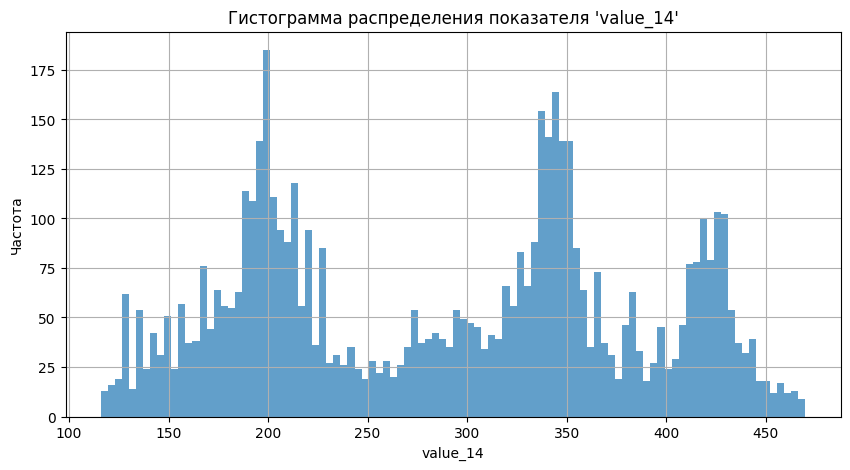

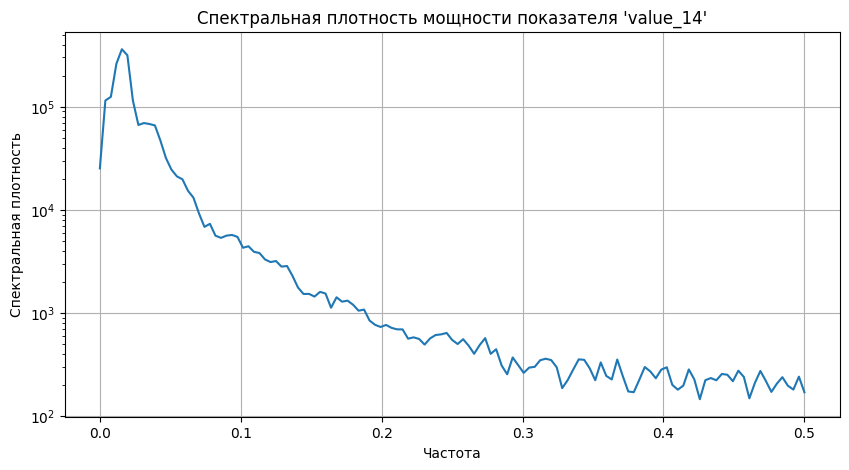

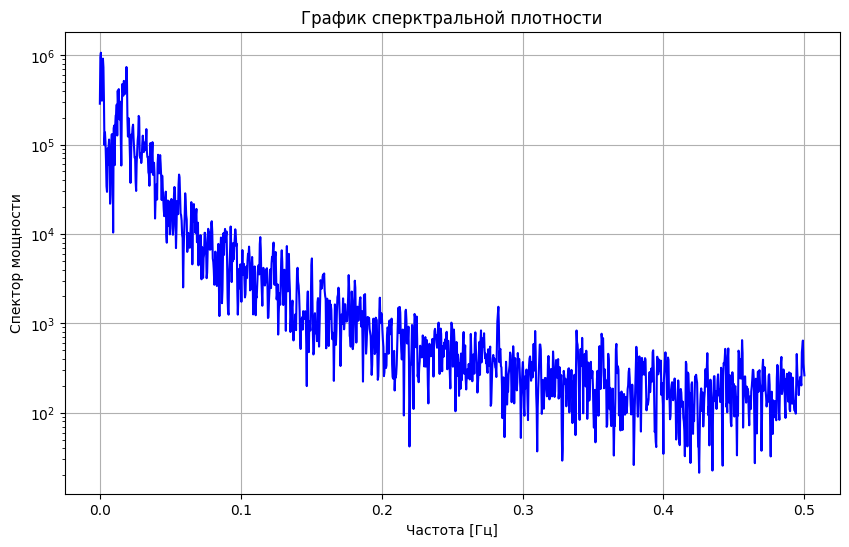

Максимальный лаг: 74


<Figure size 1000x600 with 0 Axes>

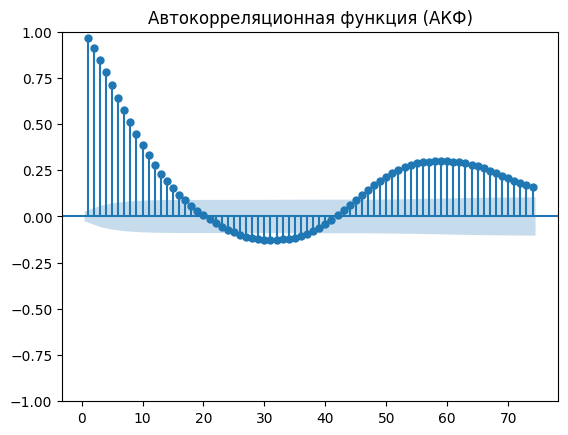

<Figure size 1000x600 with 0 Axes>

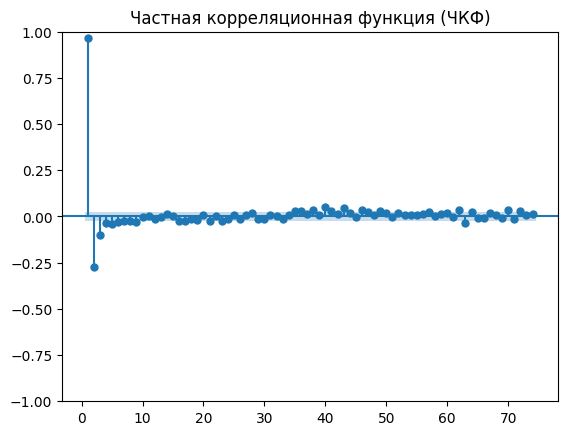

In [102]:
start_datetime = '2024-10-14 00:00'
end_datetime = '2024-10-18 23:59'

value = 'value_14'

df_filter = df[(df['mode'] == 1)]
df_filter.to_csv('statistics_14-10-2024_18-10-2024.csv', index=False)

stat_consolidated(df, value, start_datetime, end_datetime)

# Статистический анализ

Выводы по АКФ и ЧКФ
1.  Временной ряд является слабокоррелированным или независимым процессом. В таком случае стандартные модели, использующие автокорреляцию, могут оказаться неэффективными, и для анализа и прогнозирования потребуются другие подходы.
2. Анализ графика ЧКФ:
- Прямая линия на уровне "0" по вертикали:
Горизонтальная линия на уровне 0 на графике ЧКФ означает, что все частные автокорреляции за пределами первого лага равны нулю. Это указывает на то, что временной ряд не имеет значимых частных автокорреляций после первого лага.
- Вертикальный отрезок от "1" до "0" по вертикали и на уровне "0" по горизонтали:
Вертикальный отрезок на первом лаге (при значении 0 по горизонтали) показывает, что имеется значительная частичная автокорреляция на первом лаге. То есть, текущий уровень временного ряда значительно коррелирует с уровнем ряда на один лаг назад.
3. Такой график ЧКФ указывает на то, что временной ряд, вероятно, соответствует модели AR(1) (авторегрессия первого порядка). Это означает, что текущее значение ряда зависит только от его значения на один период назад, и эта зависимость сильная. Все остальные лаги не оказывают значительного влияния на текущий уровень ряда.


Функции для проведения анализа

In [ ]:
# Функция для фильтрации данных по дате
def filter_by_date(result_df, start_date, end_date):
    mask = (result_df['date'] >= start_date) & (result_df['date'] <= end_date)
    filtered_df = result_df.loc[mask]
    return filtered_df

# Функция для фильтрации данных по дате
#def filter_by_date(result_df, start_date, end_date):
    # Преобразуем колонку 'date' в формат datetime, если это еще не сделано
 #   result_df['date'] = pd.to_datetime(result_df['date'], errors='coerce')

    # Применяем фильтр по дате
  #  mask = (result_df['date'] >= start_date) & (result_df['date'] <= end_date)
   # filtered_df = result_df.loc[mask]

    # Проверка наличия данных
    #if filtered_df.empty:
     #   print("Нет данных в указанном диапазоне дат!")

def calculate_hurst_exponent(time_series, max_lag=50):
    """Рассчитывает показатель Херста с использованием R/S-анализа."""
    lags = range(2, max_lag)
    tau = [np.sqrt(np.std(np.subtract(time_series[lag:], time_series[:-lag]))) for lag in lags]
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    hurst = poly[0]*2
    return hurst


# Функция для расчёта основных статистик
def calculate_statistics(filtered_df):
    statistics = {}
    statistics['Количество данных в выборке'] = filtered_df['value'].count()
    statistics['Математическое ожидание'] = filtered_df['value'].mean()
    statistics['Медиана'] = filtered_df['value'].median()
    statistics['Максимальное значение'] = filtered_df['value'].max()
    statistics['Минимальное значение'] = filtered_df['value'].min()
    statistics['Дисперсия'] = filtered_df['value'].var()
    statistics['Среднее квадратичное отклонение'] = filtered_df['value'].std()
    statistics['Асимметрия'] = filtered_df['value'].skew()
    statistics['Эксцесс'] = filtered_df['value'].kurtosis()
    statistics['Квантили'] = filtered_df['value'].quantile([0.25, 0.5, 0.75]).to_dict()
    statistics['Коэффициент автокорреляции'] = filtered_df['value'].autocorr(lag=1)

    # Расчёт показателя Херста
    #values = filtered_df['value'].values
    #statistics['Показатель Херста'] = hurst.compute_Hc(values)

    values = filtered_df['value'].values
    statistics['Показатель Херста'] = calculate_hurst_exponent(values)

    return statistics

# Функция для построения гистограммы
def plot_histogram(filtered_df):
    plt.figure(figsize=(10, 6))
    #plt.hist(filtered_df['value'], bins=100)
    plt.hist(filtered_df['value'], bins=range(int(result_df['value'].min()), int(result_df['value'].max()) + 5, 5))
    plt.title("Гистограмма распредения")
    plt.xlabel("Значения")
    plt.ylabel("Частота")
    plt.grid(True)
    plt.show()

# Функция для построения графиков ACF и PACF
def plot_acf_pacf(filtered_df):
    n = len(filtered_df['value'])
    max_lags = int(np.sqrt(n))  # Подбор количества лагов согласно правилу Бартлетта

    print(f"Максимальный лаг: {max_lags}")

    plt.figure(figsize=(10, 6))
    plot_acf(filtered_df['value'], lags=max_lags, title='Автокорреляционная функция (АКФ)', zero=False)
    plt.show()

    plt.figure(figsize=(10, 6))
    plot_pacf(filtered_df['value'], lags=max_lags, title='Частная корреляционная функция (ЧКФ)', zero=False)
    plt.show()

# Функция для построения графика спектральной плотности
def plot_spectral_density(result_df, start_date_str, end_date_str):
    # Преобразование строк в объекты datetime
    #start_date = pd.to_datetime(start_date_str, format='%d.%m.%Y')
    #end_date = pd.to_datetime(end_date_str, format='%d.%m.%Y')

    # Фильтрация данных по дате
    filtered_df = result_df[(result_df['date'] >= start_date) & (result_df['date'] <= end_date)]

    # Выбор временного ряда для анализа
    values = filtered_df['value'].values

    # Параметры для оценки спектральной плотности
    fs = 1  # Частота дискретизации (здесь 1, так как это временной ряд)
    nperseg = len(values) // 2  # Размер сегмента (зависит от длины ряда)
    window = blackman(nperseg)  # Применение оконной функции Blackman

    # Оцениваем спектральную плотность мощности с помощью метода Welch
    frequencies, psd = welch(values, fs=fs, nperseg=nperseg, window=window)

    # Построение графика спектральной плотности
    plt.figure(figsize=(10, 6))
    plt.semilogy(frequencies, psd, color='b')  # Логарифмическая шкала для оси Y
    plt.xlim(0, frequencies.max())  # Ограничиваем ось X
    plt.title(f'График сперктральной плотности')
    plt.xlabel('Частота [Гц]')
    plt.ylabel('Спектор мощности')
    plt.grid(True)
    plt.autoscale(enable=True, axis='both', tight=None)  # Автоматическое масштабирование осей
    plt.show()

In [ ]:
# Функция для построения точечного графика
# Функция для построения точечного графика с соединением точек
def plot_connected_points(filtered_df, x_column="date", y_column="value", mode="mean"):
    """ Функция для построения точечного графика с соединением точек. :param filtered_df: Датафрейм Pandas с временным рядом. :param x_column: Название столбца, содержащего значения по оси X. :param y_column: Название столбца, содержащего значения по оси Y. :param mode: Режим выбора значения ('min', 'max', 'mean'), по умолчанию 'mean'. """
    # Проверяем, что датафрейм не пустой
    if filtered_df.empty:
        print("Нет данных для построения графика.")
        return

    # Группировка данных по дням и применение выбранного режима
    grouped_data = filtered_df.groupby(pd.Grouper(key=x_column, freq='D'))[y_column]

    if mode == "min":
        y_values = grouped_data.min()
    elif mode == "max":
        y_values = grouped_data.max()
    elif mode == "mean":
        y_values = grouped_data.mean()
    else:
        print(f"Неизвестный режим '{mode}'. Доступные варианты: 'min', 'max', 'mean'.")
        return

    # Создаем фигуру и оси для графика
    fig, ax = plt.subplots(figsize=(12, 6))

    # Рисуем точки
    ax.scatter(y_values.index, y_values.values, color='blue', label=f"{y_column} (точки)")

    # Соединяем точки линиями
    ax.plot(y_values.index, y_values.values, color='black', label=f"{y_column} (линия)", linewidth=1)

    # Настраиваем метки осей и заголовок
    ax.set_title(f"Построение графика ({y_column}, режим: {mode.upper()})")
    ax.set_xlabel(x_column)
    ax.set_ylabel(y_column)

    # Включаем сетку для удобства чтения графика
    ax.grid(True)

    # Форматируем метки дат на оси X
    if x_column == "date":
        date_formatter = mdates.DateFormatter('%d.%m.%Y')  # Формат 'День.Месяц.Год'
        ax.xaxis.set_major_formatter(date_formatter)

    # Показываем легенду
    ax.legend()

    # Отображаем график
    plt.show()

In [ ]:
# Функция для построения графика по дням
def plot_days(filtered_df, x_column="date", y_column="value", mode="mean"):
    """ Функция для построения графика по дням. :param filtered_df: Датафрейм Pandas с временным рядом. :param x_column: Название столбца, содержащего значения по оси X. :param y_column: Название столбца, содержащего значения по оси Y. :param mode: Режим выбора значения ('min', 'max', 'mean'), по умолчанию 'mean'. """
    # Проверяем, что датафрейм не пустой
    if filtered_df.empty:
        print("Нет данных для построения графика.")
        return

    # Группировка данных по дням и применение выбранного режима
    grouped_data = filtered_df.groupby(pd.Grouper(key=x_column, freq='D'))[y_column]

    if mode == "min":
        y_values = grouped_data.min()
    elif mode == "max":
        y_values = grouped_data.max()
    elif mode == "mean":
        y_values = grouped_data.mean()
    else:
        print(f"Неизвестный режим '{mode}'. Доступные варианты: 'min', 'max', 'mean'.")
        return

    # Создаем фигуру и оси для графика
    fig, ax = plt.subplots(figsize=(12, 6))

    # Рисуем точки
    ax.scatter(y_values.index, y_values.values, color='blue', label=f"{y_column} (точки)")

    # Соединяем точки линиями
    ax.plot(y_values.index, y_values.values, color='black', label=f"{y_column} (линия)", linewidth=1)

    # Настраиваем метки осей и заголовок
    ax.set_title(f"Построение графика ({y_column}) по дням")
    ax.set_xlabel(x_column)
    ax.set_ylabel(y_column)

    # Включаем сетку для удобства чтения графика
    ax.grid(True)

    # Форматируем метки дат на оси X
    date_formatter = mdates.DateFormatter('%d.%m.%Y')  # Формат 'День.Месяц.Год'
    ax.xaxis.set_major_formatter(date_formatter)

    # Показываем легенду
    ax.legend()

    # Отображаем график
    plt.show()


# Функция для построения графика по часам
def plot_hours(filtered_df, x_column="time", y_column="value", mode="max"):
    """ Функция для построения графика по часам. :param filtered_df: Датафрейм Pandas с временным рядом. :param x_column: Название столбца, содержащего время. :param y_column: Название столбца, содержащего значения. :param mode: Режим отображения значений ('max', 'min', 'mean'), по умолчанию 'max'. """
    # Проверяем, что датафрейм не пустой
    if filtered_df.empty:
        print("Нет данных для построения графика.")
        return

    # Преобразуем столбец time в формат времени
    filtered_df[x_column] = pd.to_datetime(filtered_df[x_column], format='%H:%M')

    # Устанавливаем index как DatetimeIndex
    filtered_df.set_index(x_column, inplace=True)

    # Группировка данных по времени и применение выбранного режима
    grouped_data = filtered_df.resample(rule='T')[y_column].agg(mode)

    # Создаем фигуру и оси для графика
    fig, ax = plt.subplots(figsize=(12, 6))

    # Устанавливаем белый фон для всей фигуры
    fig.patch.set_facecolor('white')

    # Устанавливаем белый фон для области осей
    ax.patch.set_facecolor('white')

    # Рисуем маленькие точки
    ax.scatter(grouped_data.index, grouped_data, s=5, color='#007acc', label=f"{y_column} ({mode.capitalize()})")

    # Соединяем точки тонкой голубой линией
    ax.plot(grouped_data.index, grouped_data, color='#99ccff', linewidth=1, label=f"{y_column} (линия)")

    # Настраиваем метки осей и заголовок
    ax.set_title(f"Построение графика ({y_column}, режим: {mode.capitalize()})")
    ax.set_xlabel(x_column)
    ax.set_ylabel(y_column)

    # Включаем сетку для удобства чтения графика
    ax.grid(True)

    # Устанавливаем часовой локатор для меток времени
    ax.xaxis.set_major_locator(HourLocator(interval=1))  # Метки ровно по часам

    # Устанавливаем минутный локатор для мелких меток
    ax.xaxis.set_minor_locator(MinuteLocator(byminute=[0, 15, 30, 45]))  # Мелкие метки каждые 15 минут

    # Форматируем метки времени на оси X
    time_formatter = mdates.DateFormatter('%H:%M')  # Формат 'Часы:Минуты'
    ax.xaxis.set_major_formatter(time_formatter)

    # Уменьшаем размер шрифта меток на оси X
    ax.tick_params(axis='x', labelsize=8)

    # Показываем легенду
    ax.legend()

    # Отображаем график
    plt.show()

In [ ]:
# Функция для построения графика по часам
def plot_selected_interval(filtered_df, x_column="time", y_column="value"):
    """ Функция для построения графика по часам. :param filtered_df: Датафрейм Pandas с временным рядом. :param x_column: Название столбца, содержащего время. :param y_column: Название столбца, содержащего значения. """
    # Проверяем, что датафрейм не пустой
    if filtered_df.empty:
        print("Нет данных для построения графика.")
        return

    # Устанавливаем index как DatetimeIndex
    filtered_df.set_index(x_column, inplace=True)

    # Создаем фигуру и оси для графика
    fig, ax = plt.subplots(figsize=(12, 6))

    # Устанавливаем белый фон для всей фигуры
    fig.patch.set_facecolor('white')

    # Устанавливаем белый фон для области осей
    ax.patch.set_facecolor('white')

    # Рисуем маленькие точки
    ax.scatter(filtered_df.index, filtered_df[y_column], s=5, color='#007acc', label=f"{y_column} (точки)")

    # Соединяем точки тонкой голубой линией
    ax.plot(filtered_df.index, filtered_df[y_column], color='#99ccff', linewidth=1, label=f"{y_column} (линия)")

    # Настраиваем метки осей и заголовок
    ax.set_title(f"Построение графика ({y_column})")
    ax.set_xlabel(x_column)
    ax.set_ylabel(y_column)

    # Включаем сетку для удобства чтения графика
    ax.grid(True)

    # Устанавливаем часовой локатор для меток времени
    ax.xaxis.set_major_locator(HourLocator(interval=1))  # Метки ровно по часам

    # Устанавливаем минутный локатор для мелких меток
    ax.xaxis.set_minor_locator(MinuteLocator(byminute=[0, 15, 30, 45]))  # Мелкие метки каждые 15 минут

    # Форматируем метки времени на оси X
    time_formatter = mdates.DateFormatter('%H:%M')  # Формат 'Часы:Минуты'
    ax.xaxis.set_major_formatter(time_formatter)

    # Уменьшаем размер шрифта меток на оси X
    ax.tick_params(axis='x', labelsize=8)

    # Показываем легенду
    ax.legend()

    # Отображаем график
    plt.show()

Основные статистические показатели
период: 05.07.2024 - 05.07.2024
-----------------------------------------------------------------------------
| Показатель                      | Значение                                                     |
|---------------------------------|--------------------------------------------------------------|
| Количество данных в выборке     | 1440                                                         |
| Математическое ожидание         | 242.26145833333334                                           |
| Медиана                         | 283.0769230769231                                            |
| Максимальное значение           | 545.0                                                        |
| Минимальное значение            | 0.0                                                          |
| Дисперсия                       | 27631.597699291397                                           |
| Среднее квадратичное отклонение | 166.22754795548            

<ipython-input-118-e1777331c67c>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[x_column] = pd.to_datetime(filtered_df[x_column], format='%H:%M')
<ipython-input-118-e1777331c67c>:65: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  grouped_data = filtered_df.resample(rule='T')[y_column].agg(mode)


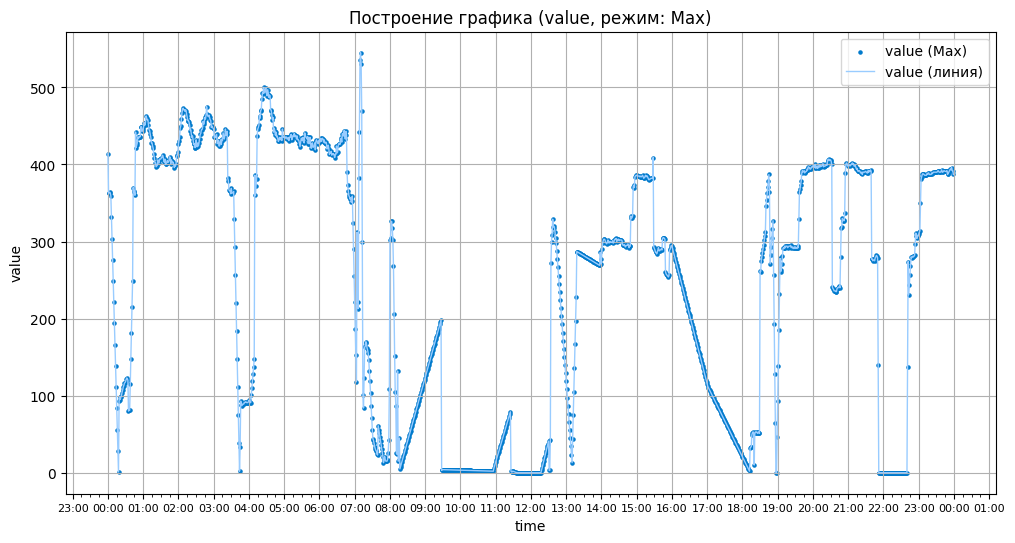

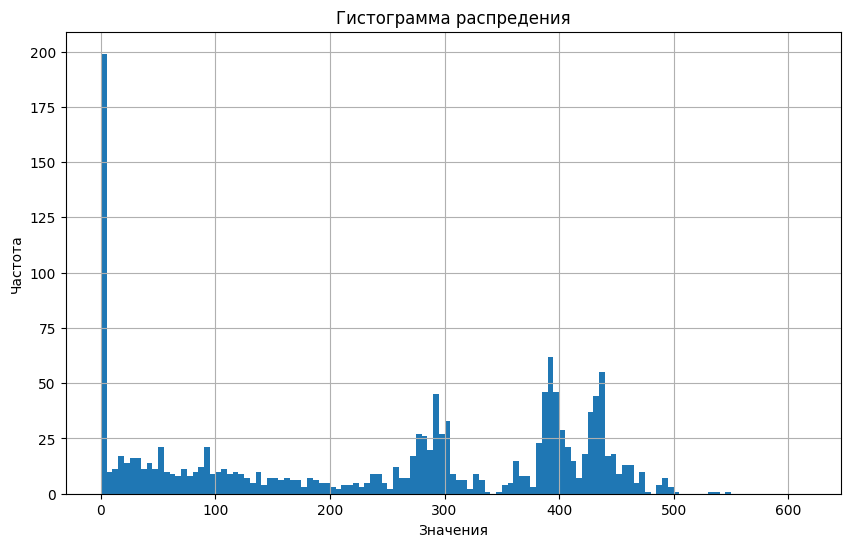

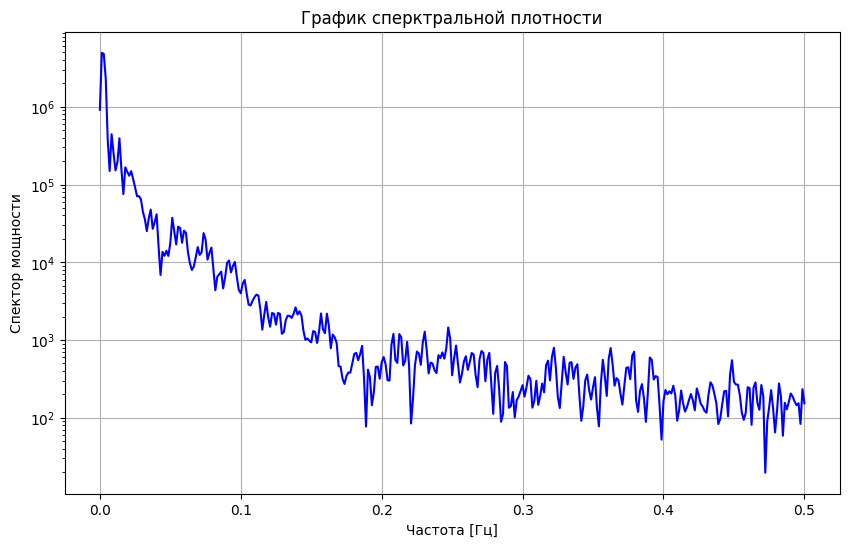

Максимальный лаг: 37


<Figure size 1000x600 with 0 Axes>

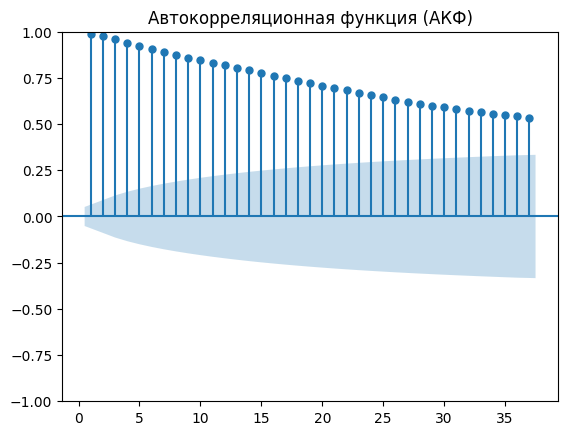

<Figure size 1000x600 with 0 Axes>

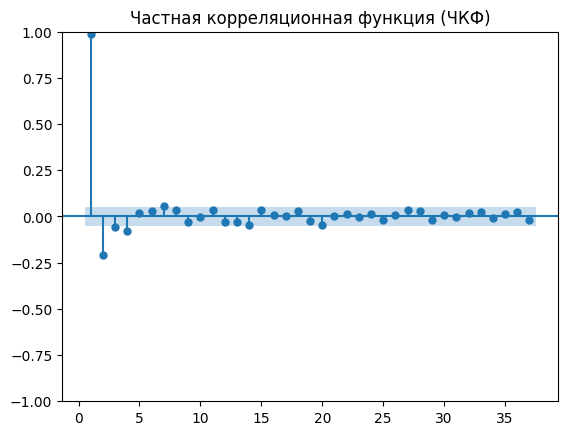

NameError: name 'filter_by_date_and_time' is not defined

In [ ]:
# Задание дат в формате DD.MM.YYYY
start_date_str = "05.07.2024"
end_date_str = "05.07.2024"



# Преобразование строк в объекты datetime
start_date = pd.to_datetime(start_date_str, format="%d.%m.%Y")
end_date = pd.to_datetime(end_date_str, format="%d.%m.%Y")


# Фильтруем данные по дате
filtered_df = filter_by_date(result_df, start_date, end_date)

# Рассчитываем статистику
statistics = calculate_statistics(filtered_df)


# Формируем таблицу с результатами
table_headers = ['Показатель', 'Значение']
table_data = [(key, value) for key, value in statistics.items()]
table_data.extend([
    ('Квантиль 25%', statistics['Квантили'][0.25]),
    ('Квантиль 50%', statistics['Квантили'][0.5]),
    ('Квантиль 75%', statistics['Квантили'][0.75])
])
table = tabulate(table_data, headers=table_headers, tablefmt="github", floatfmt=".4f")
print('Основные статистические показатели')
print(f"период: {start_date_str} - {end_date_str}")
print("-"*77)
print(table)
print("-"*77)


# Строим график временного ряда
if start_date == end_date:
    plot_hours(filtered_df, x_column="time", y_column="value", mode="max")  # По умолчанию 'max'
else:
    plot_days(filtered_df, x_column="date", y_column="value", mode="mean")




# Строим гистограмму распределения
plot_histogram(filtered_df)


# Строим график спектральной плотности
#plot_spectral_density(result_df, start_date_str, end_date_str)
plot_spectral_density(result_df, start_date, end_date)


# Строим графики ACF и PACF
plot_acf_pacf(filtered_df)






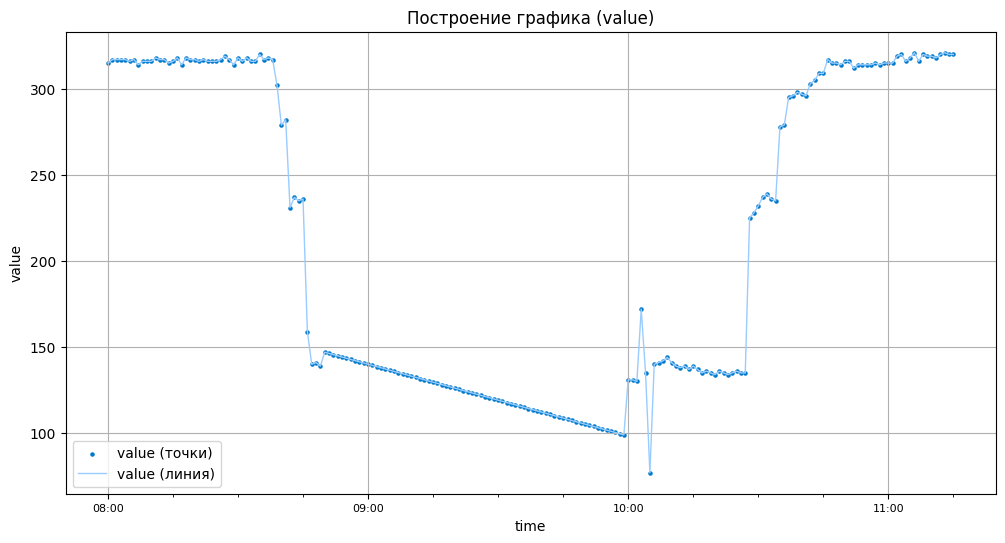

In [ ]:
# Функция для фильтрации данных по дате и времени
def filter_by_date_and_time(result_df, selected_date, start_time, end_time):
    # Фильтруем данные по дате
    date_mask = result_df['date'] == selected_date
    filtered_by_date = result_df[date_mask].copy()  # Создаем явную копию

    # Преобразуем столбец time в формат времени
    filtered_by_date['time'] = pd.to_datetime(filtered_by_date['time'], format='%H:%M')

    # Фильтруем данные по времени
    time_mask = (filtered_by_date['time'] >= start_time) & (filtered_by_date['time'] <= end_time)
    filtered_by_time = filtered_by_date[time_mask]

    return filtered_by_time



# Задание даты и интервала времени
selected_date = pd.to_datetime("05.04.2024", format="%d.%m.%Y")
start_time = pd.to_datetime("08:00", format='%H:%M')
end_time = pd.to_datetime("11:15", format='%H:%M')

# Предположим, что result_df - ваш исходный датафрейм
filtered_df = filter_by_date_and_time(result_df, selected_date, start_time, end_time)

# Вызов функции построения графика
if not filtered_df.empty:
    plot_selected_interval(filtered_df, x_column="time", y_column="value")
else:
    print("Нет данных для выбранного интервала времени.")

In [ ]:
time_formatter = mdates.DateFormatter('%H:%M:%S')  # Формат 'Часы:Минуты:Секунды'
print (time_formatter)

График спектральной плотности мощности (PSD) — это важный инструмент для анализа временных рядов, позволяющий выявить доминирующие частоты и характер колебаний в данных. Чтобы правильно расшифровать график, нужно понимать его компоненты и то, какую информацию они предоставляют.

Компоненты графика PSD:
Ось X (частоты):
Представляет частоты, на которых оценивается мощность сигнала.
Единицы измерения обычно Гц (герцы), что означает количество циклов в секунду.
Ось Y (спектральная плотность мощности):
Показывает интенсивность (мощность) сигнала на каждой частоте.
Обычно измеряется в квадратных единицах сигнала на герц (
V
2
/
H
z
V
2
 /Hz, если речь идет о напряжении).
Пики на графике:
Высокие пики указывают на присутствие сильных регулярных колебаний на определенных частотах.
Если пик наблюдается на определенной частоте, это значит, что большая доля энергии сигнала приходится на эту частоту.
Форма кривой:
Равномерно распределённая мощность по всему спектру может свидетельствовать о белом шуме.
Резкое падение мощности на высоких частотах может говорить о низкочастотном характере сигнала.
Интерпретация графика PSD:
Высокие пики:
Если на графике видны высокие пики на конкретных частотах, это указывает на наличие регулярных колебаний с этими частотами.
Например, пик на частоте 50 Гц может указывать на наличие индустриальных помех (электропитание).
Белый шум:
Если график представляет собой равномерное распределение мощности по всем частотам, это признак белого шума.
Белый шум характеризуется отсутствием доминирующих частот и равномерным распределением энергии по всему спектру.
Низкочастотные сигналы:
Если мощность резко падает на высоких частотах, это говорит о том, что сигнал носит низкочастотный характер.
Такие сигналы могут встречаться в природных процессах, где преобладают медленные изменения.
Частотно-селективные фильтры:
Если у вас есть информация о частотных характеристиках системы или процессов, вы можете сравнивать их с пиками на графике PSD, чтобы оценить, соответствуют ли они ожидаемым характеристикам.
Сигнал против шума:
График PSD помогает идентифицировать сильные сигналы на фоне шума. Пики указывают на наличие полезных сигналов, тогда как фоновый уровень может указывать на уровень шума.
Пример:
Представим, что у вас есть график PSD, на котором наблюдаются два пика: один на частоте 50 Гц, а другой на частоте 250 Гц. Это может означать следующее:

Пик на 50 Гц может быть связан с индустриальными помехами (сетевое питание).
Пик на 250 Гц может указывать на специфичные колебания в исследуемом процессе.
Практическая польза:
График PSD важен для:

Анализа сигналов в инженерных приложениях (например, выявление помех).
Исследования биосигналов (например, электроэнцефалография, электрокардиография).
Мониторинга механических систем (например, диагностика вибрации машин).
Экономического анализа (например, исследование сезонных колебаний).
Заключение:
График спектральной плотности мощности помогает понять частотные составляющие сигнала, выявлять регулярные колебания и оценивать соотношение сигнала и шума. Понимание формы графика и положения пиков позволяет делать выводы о природе исследуемых данных и процессов.

Пояснение:
hurst.compute_Hc(values):
Эта функция из библиотеки hurst вычисляет показатель Херста для заданного временного ряда. Входные данные должны быть в виде одномерного массива.
Результаты:
1. Значение показателя Херста будет находиться в диапазоне от 0 до 1
2. Чем ближе значение к 0.5, тем больше ряд напоминает случайное блуждание.
3. Значения выше 0.5 указывают на персистентность, а ниже 0.5 — на антиперсистентность.
4. Дополнительные советы:
- Длина временного ряда:
- Чем длиннее временной ряд, тем точнее будет расчёт показателя Херста.
- Рекомендуется использовать ряды длиной не менее нескольких сотен значений.
4.2. Фильтрация данных: Если данные зашумлены, предварительная фильтрация может улучшить точность расчёта.


1. Интерпретация показателя Херста:
Показатель Херста (H) варьируется от 0 до 1:
- H = 0.5: Временной ряд ведёт себя как случайное блуждание (броуновское движение). Это указывает на отсутствие долговременной памяти в данных.
- H < 0.5: Ряд имеет свойство антиперсистентности. Это означает, что временные серии склонны изменять своё направление чаще, чем случайное блуждание. Например, если ряд растёт, то вероятность падения увеличивается.
- H > 0.5: Ряд обладает персистентностью. Это означает, что временные серии сохраняют своё направление дольше, чем случайное блуждание. Если ряд растёт, то вероятность продолжения роста выше.
2. Ваш результат:
- H = 0.4623129129941261 указывает на то, что ваш временной ряд имеет антиперсистентность. Это значит, что серия значений имеет тенденцию чаще изменять своё направление, чем в случае случайного блуждания. Это может быть следствием наличия шумов или флуктуаций в данных.